In [1]:
import os
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import glob
import pandas as pd
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy


In [15]:
# edge_folder = '/gpfs/scratch1/shared/amftrackflow/Drp_downs/20220118_Plate537/20220118_Plate537_005/Analysis/edge (7, 6)/'
vid_folder = '/gpfs/scratch1/shared/amftrackflow/Drp_downs/20230201_Plate528/20230126_Plate528_05/'

edge_folders = glob.glob(os.path.join(vid_folder, 'Analysis/*/'))
for i, folder in enumerate(edge_folders):
    edge_name = folder.split('/')[-2][5:]
    bin_imgs = glob.glob(os.path.join(folder, '* 1 fluxforw.npy'))
    print(f'folder {i} of edge {edge_name} has {len(bin_imgs)} bin depth')

folder 0 of edge (6, 3) has 0 bin depth
folder 1 of edge (79, 12) has 0 bin depth
folder 2 of edge (7, 6) has 0 bin depth
folder 3 of edge (6, 0) has 0 bin depth
folder 4 of edge (45, 4) has 0 bin depth
folder 5 of edge (5, 4) has 8 bin depth
folder 6 of edge (4, 3) has 8 bin depth
folder 7 of edge (4, 0) has 8 bin depth


## Here is where you put in the image parameters and the edges you want to see

In [16]:
edge_interests = [5,6,7]
magnification = 50
binning = 2
space_pixel_size = 2 * 1.725 / (magnification) * binning


For Kirchhoff law analysis, we need to assemble some graph arrays.

Here we list out all the nodes, and find their junctions. This results in a dictionary with first a junction as key, its branching nodes as entries, and the flow direction relative to the junction as entry to those. Flow direction is determined by the naming scheme of the edge itself. Up until now, this is a reliable way to determine flow relative to a junction.

In [17]:
junctions = {}

for i in edge_interests:
    edge_folder = edge_folders[i]
    edge_name = edge_folder.split('/')[-2][5:][1:-1].split(', ')
    edge_array = [int(node) for node in edge_name]
    if edge_array[0] not in junctions:
        junctions[edge_array[0]] = [[edge_array[1], -1]]
    else:
        junctions[edge_array[0]].append([edge_array[1],-1])
        
    if edge_array[1] not in junctions:
        junctions[edge_array[1]] = [[edge_array[0], -2]]
    else:
        junctions[edge_array[1]].append([edge_array[0],-2])

nodes = [key for key in junctions]
for node in nodes:
    if len(junctions[node])==1:
        del junctions[node]
    else:
        junctions[node] = np.array(junctions[node])
        
print(junctions)


{4: array([[ 5, -2],
       [ 3, -1],
       [ 0, -1]])}


The next batch of code extracts all the transport information from the multiple bin sets we've made. This is put into an array for further junction analysis

(8, 600)
4
(8, 600)


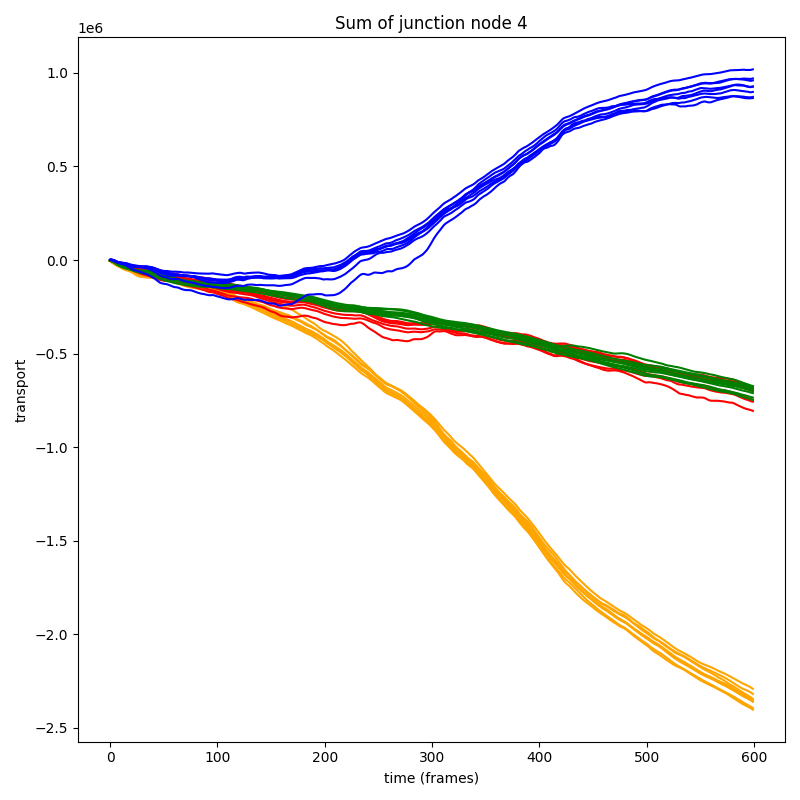

In [32]:
all_transport_plots = {}

fig_trans, ax_trans = plt.subplots(figsize=(8,8))


for k, i in enumerate(edge_interests):
    edge_folder = edge_folders[i]
    img_max = 100
    edge_name = edge_folder.split('/')[-2][5:]

    flux_forw_list = glob.glob(edge_folder + '(*) * * fluxf*.npy')
    flux_back_list = glob.glob(edge_folder + '(*) * * fluxb*.npy')
    bin_forw_list = {}
    bin_back_list = {}

    for entry in flux_forw_list:
        if entry.split(' ')[-3] not in bin_forw_list:
            bin_forw_list[entry.split(' ')[-3]] = []
        bin_forw_list[entry.split(' ')[-3]].append(entry)

    for entry in flux_back_list:
        if entry.split(' ')[-3] not in bin_back_list:
            bin_back_list[entry.split(' ')[-3]] = []
        bin_back_list[entry.split(' ')[-3]].append(entry)

    for bin_nr in bin_forw_list:
        bin_forw_list[bin_nr].sort()
    for bin_nr in bin_back_list:
        bin_back_list[bin_nr].sort()

    bin_list = [bin_forw_list, bin_back_list]  

    
    tran_img_mean = []
    tran_mean_total = []

    for j, bin_entry in enumerate(sorted(bin_forw_list)):
        bin_amnt = int(bin_entry)
        tran_img = []
        for l in range(bin_amnt):
            img_forw = np.load(bin_list[0][bin_entry][l])
            img_back = np.load(bin_list[1][bin_entry][l])
            img_tot  = np.nansum((img_forw, img_back), 0)
            img_max_try  = np.nanmax([np.nanmax(abs(img_forw.flatten())), np.nanmax(abs(img_back.flatten()))])
            img_max = np.max([img_max_try, img_max])
            tran_img.append(np.cumsum(img_tot, axis=0))            
        tran_img_mean.append(np.mean(tran_img, axis=0))
        tran_mean = np.sum(tran_img_mean[j], axis=1) * space_pixel_size
#         print(tran_mean.shape)
        tran_mean_total.append(tran_mean)
        ax_trans.plot(tran_mean, label=f'Mean of {bin_amnt}-fold partition', c=['orange', 'red', 'green'][k])
    
#     ax_trans.legend()
    ax_trans.set_xlabel('time (frames)')
    ax_trans.set_ylabel('transport')
    ax_trans.set_title(f'Edge {edge_name} transport')
    fig_trans.tight_layout()
    all_transport_plots[edge_name] = np.array(tran_mean_total)


print(np.array(tran_mean_total).shape)
junction_sum = {}

for key in junctions:
    junction_sum[key] = np.zeros(np.array(tran_mean_total).shape)
# print(junction_sum)

for key in all_transport_plots:
#     print(key)
    edge_array = [int(node) for node in key[1:-1].split(', ')]
    if edge_array[0] in junctions:
#         index = (np.where(junctions[edge_array[0]] == edge_array[1]))[0]
        junction_sum[edge_array[0]] += all_transport_plots[key]
#         print(junction_sum[edge_array[0]])
#         print(index)
        
    if edge_array[1] in junctions:        
        junction_sum[edge_array[1]] -= all_transport_plots[key]

#         index = (np.where(junctions[edge_array[1]] == edge_array[0]))[0]
#         print(index)

# print(junction_sum)
for key in junction_sum:
    print(key)
#     fig, ax = plt.subplots(figsize=(9,9))
    for i in range(len(junction_sum[key])):
        ax_trans.plot(junction_sum[key][i], c='blue')
        ax_trans.set_title(f'Sum of junction node {key}')
        
print(np.array(tran_mean_total).shape)

(8, 600)
4
(8, 600)


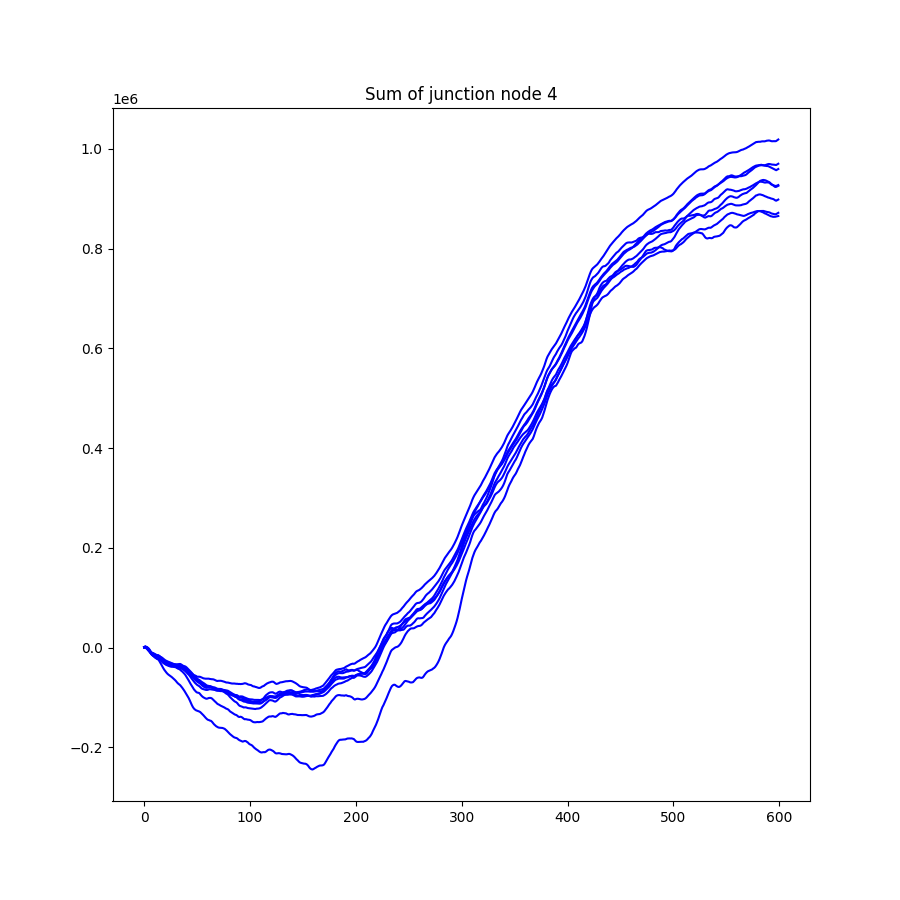